In [229]:
import datetime
import importlib
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

import utils
from utils.download import get_data

In [230]:
_ = importlib.reload(utils.download)

In [231]:
data, params = get_data()

[*********************100%%**********************]  1 of 1 completed


In [232]:
data['returns'] = data.interpolate(type='linear').pct_change()

In [233]:
train, test = data.loc[:params['test']-datetime.timedelta(days=1), ], data.loc[params['test']:, ]

# Metoda historyczna

In [234]:
alpha = .95

In [258]:
data['var95'] = data.returns.rolling(window=125).quantile(alpha)

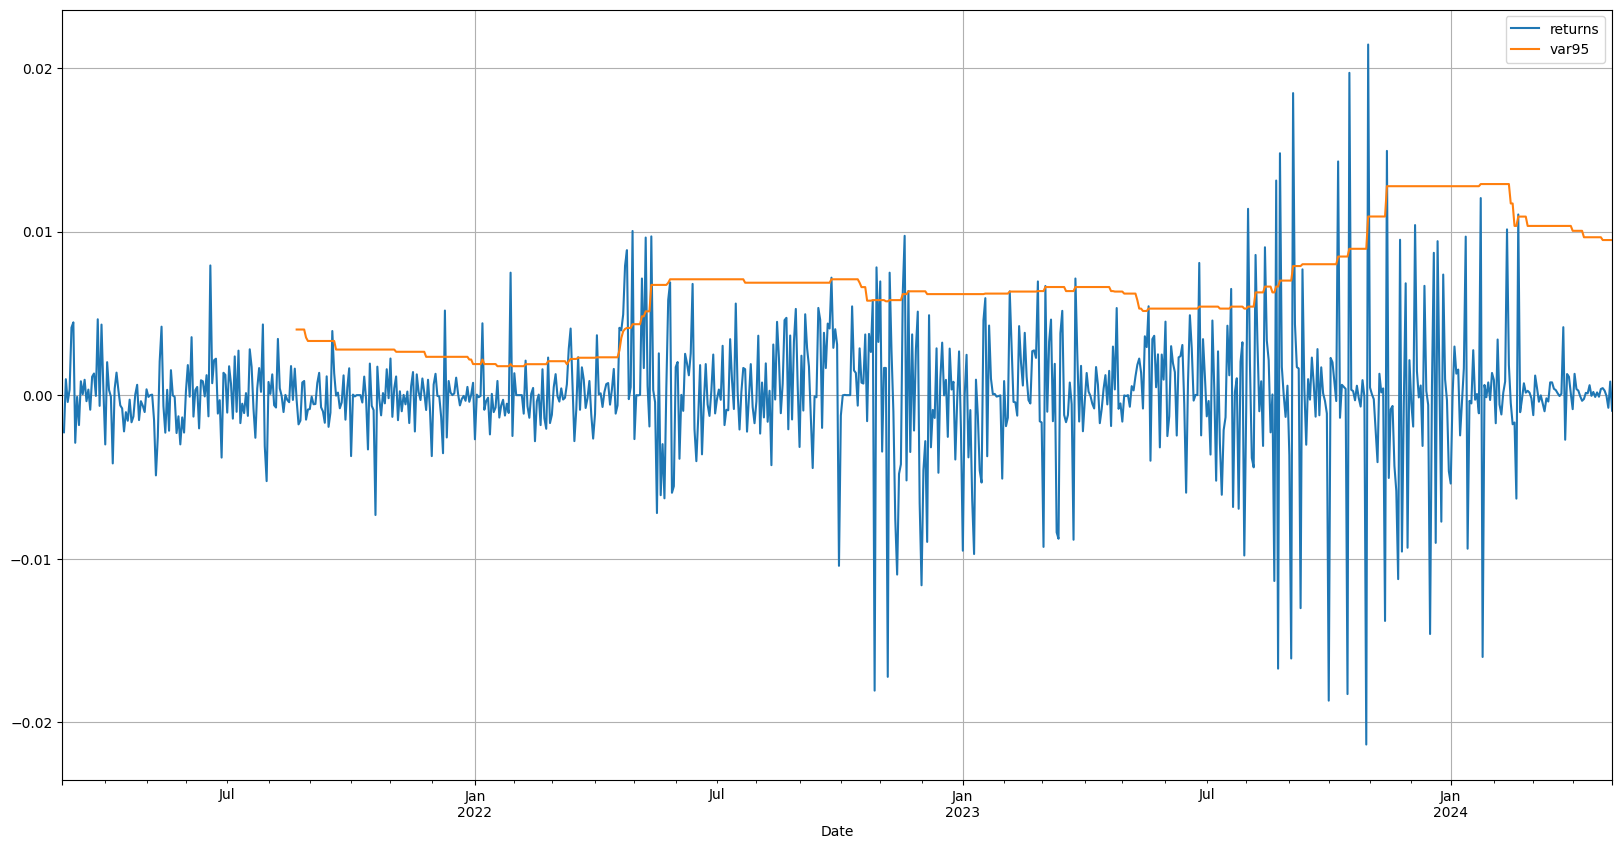

In [259]:
fig, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95']].\
    plot(ax=ax, grid=True)

In [260]:
data['exceeds'] = np.where(data['returns'] > data['var95'], 1, 0)
data.loc[data['var95'].isna(), 'exceeds'] = np.nan
data['procent przekroczeń'] = data.exceeds.rolling(window=50).sum()/50

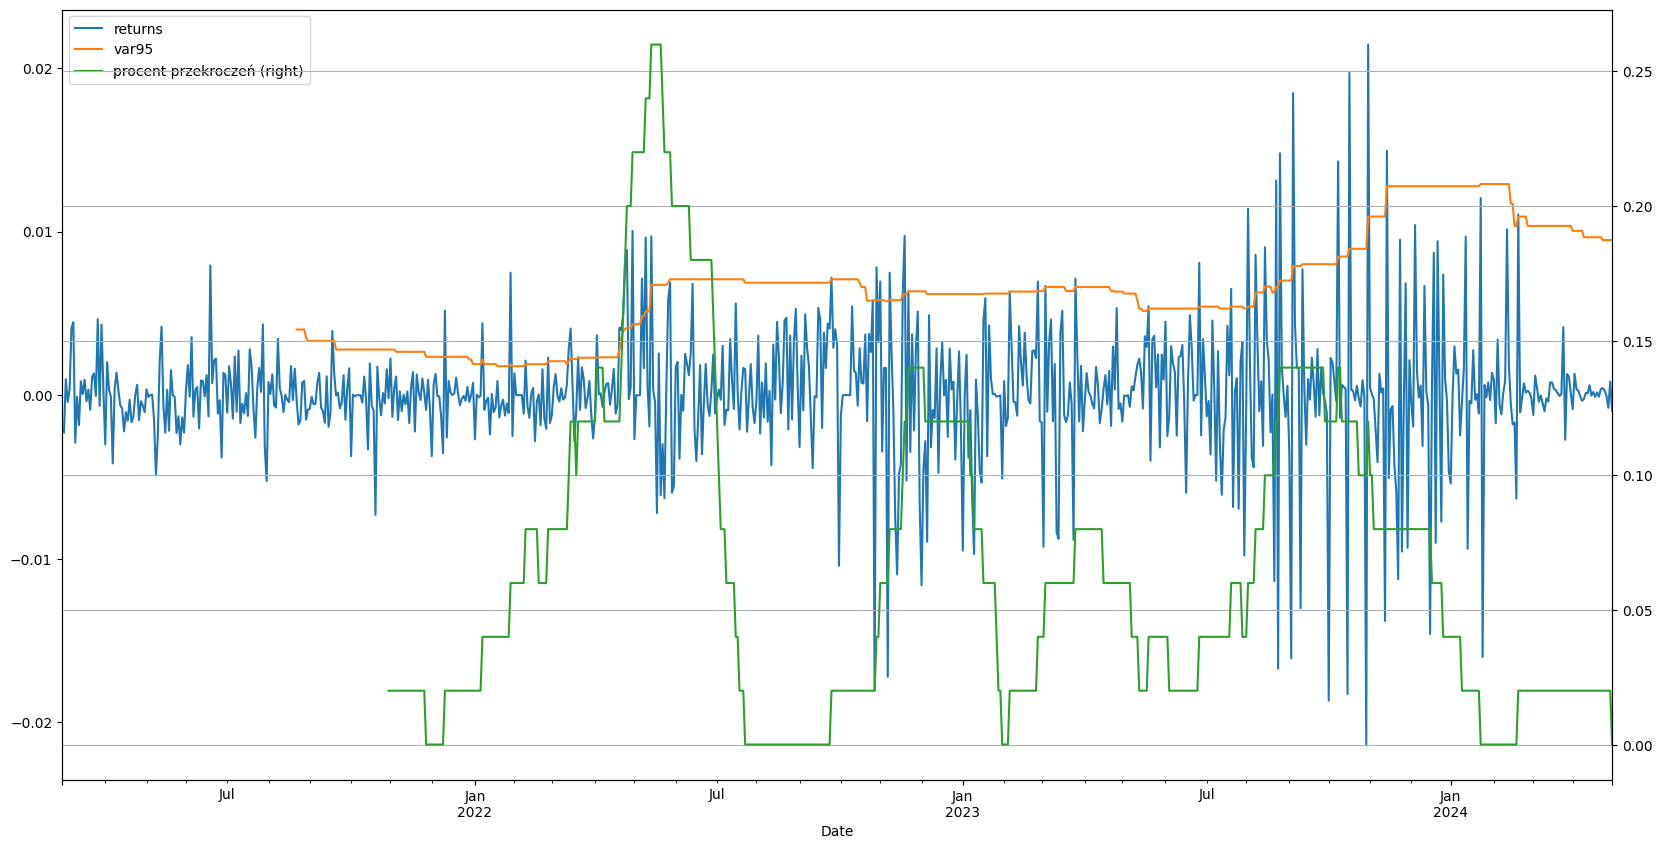

In [262]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95', 'procent przekroczeń']].plot(ax=ax, secondary_y=['procent przekroczeń'], grid=True)

## Testowanie wsteczne

In [263]:
I = data.dropna().exceeds # wektor przekroczeń

### Rozkład dwumianowy

In [264]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'.\
    format(*map(lambda x: np.round(x, 3),
                [I.mean(), alpha, 1- alpha,
                 I.var(), alpha, alpha, alpha * (1 - alpha)])))

Średnia z przekroczeń = 0.066, 1 - 0.95 = 0.05.
Wariancja z przekroczeń = 0.062, 0.95(1 - 0.95) = 0.048.


In [265]:
stats.binomtest(int(I.sum()), n=I.size, p=1-alpha)

BinomTestResult(k=43, n=653, alternative='two-sided', statistic=0.06584992343032159, pvalue=0.07167637808925026)

# Metoda ważonej symulacji historycznej

In [242]:
lam = params['lambda']
alpha = 0.95

In [243]:
def weighted_var(losses):
    w1 = 1 / np.sum(lam ** np.arange(len(losses)))
    weights = w1 * lam ** np.arange(len(losses))
    df = pd.DataFrame({'losses': losses, 'weights': weights}).reset_index(drop=True)
    df = df.sort_values(by='losses', ascending=True, ignore_index=True)
    df.weights = df.weights.cumsum()
    return df.loc[df.weights.searchsorted(alpha)-1, 'losses']

In [251]:
data['var95_ważony'] = data.returns.rolling(window=125).agg(weighted_var)

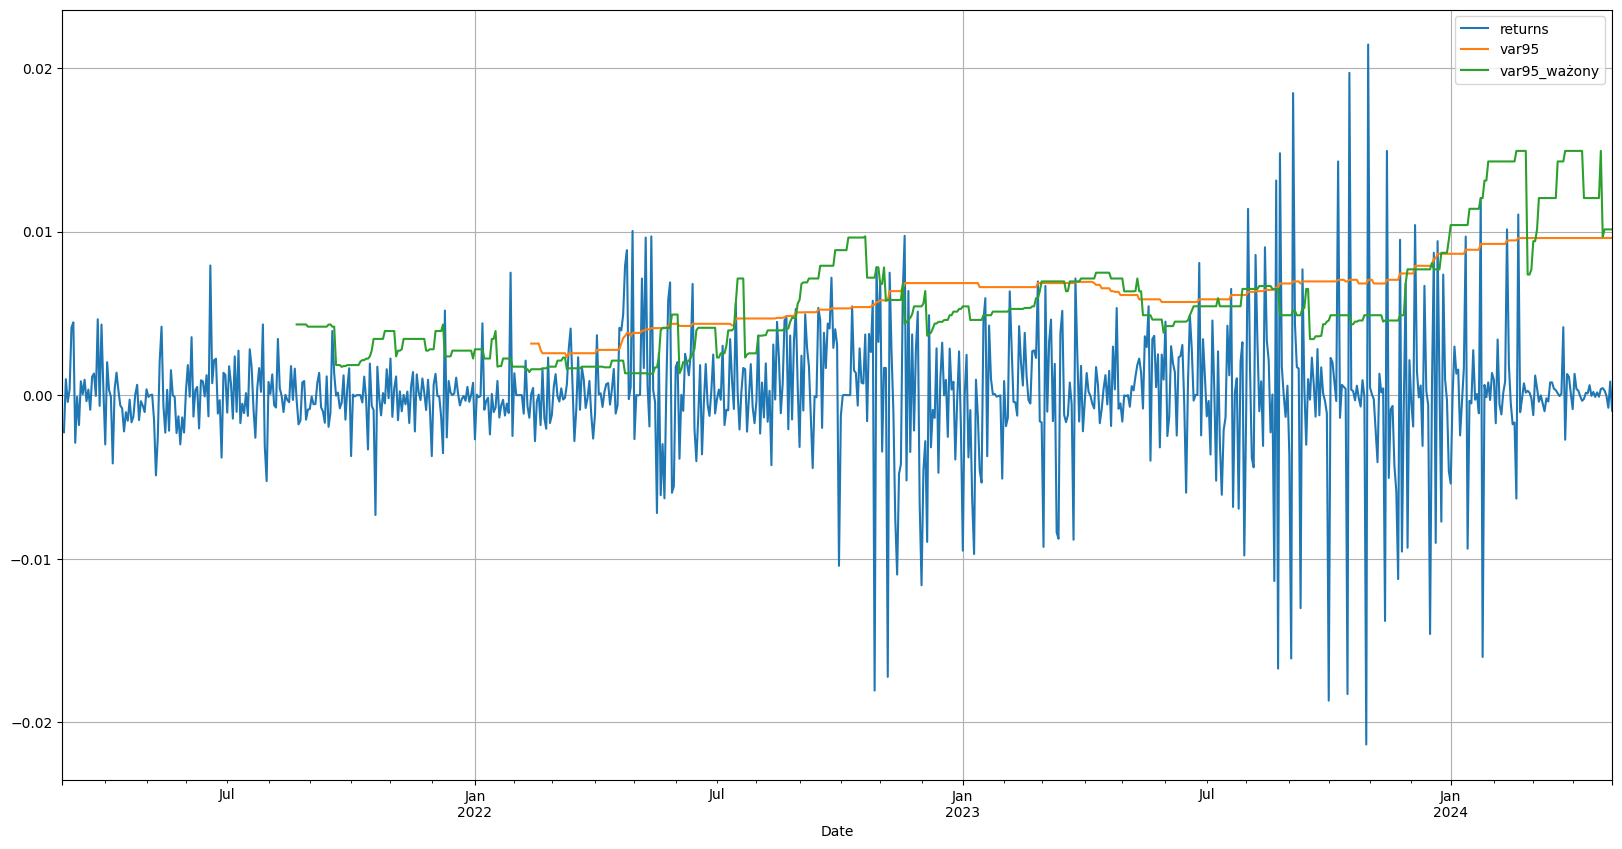

In [252]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95','var95_ważony']].plot(grid=True, ax=ax)

In [253]:
data['exceeds_ważony'] = np.where(data['returns'] > data['var95_ważony'], 1, 0)
data.loc[data['var95_ważony'].isna(), 'exceeds_ważony'] = np.nan
data['procent przekroczeń (ważony)'] = data.exceeds_ważony.rolling(window=50).sum() / 50

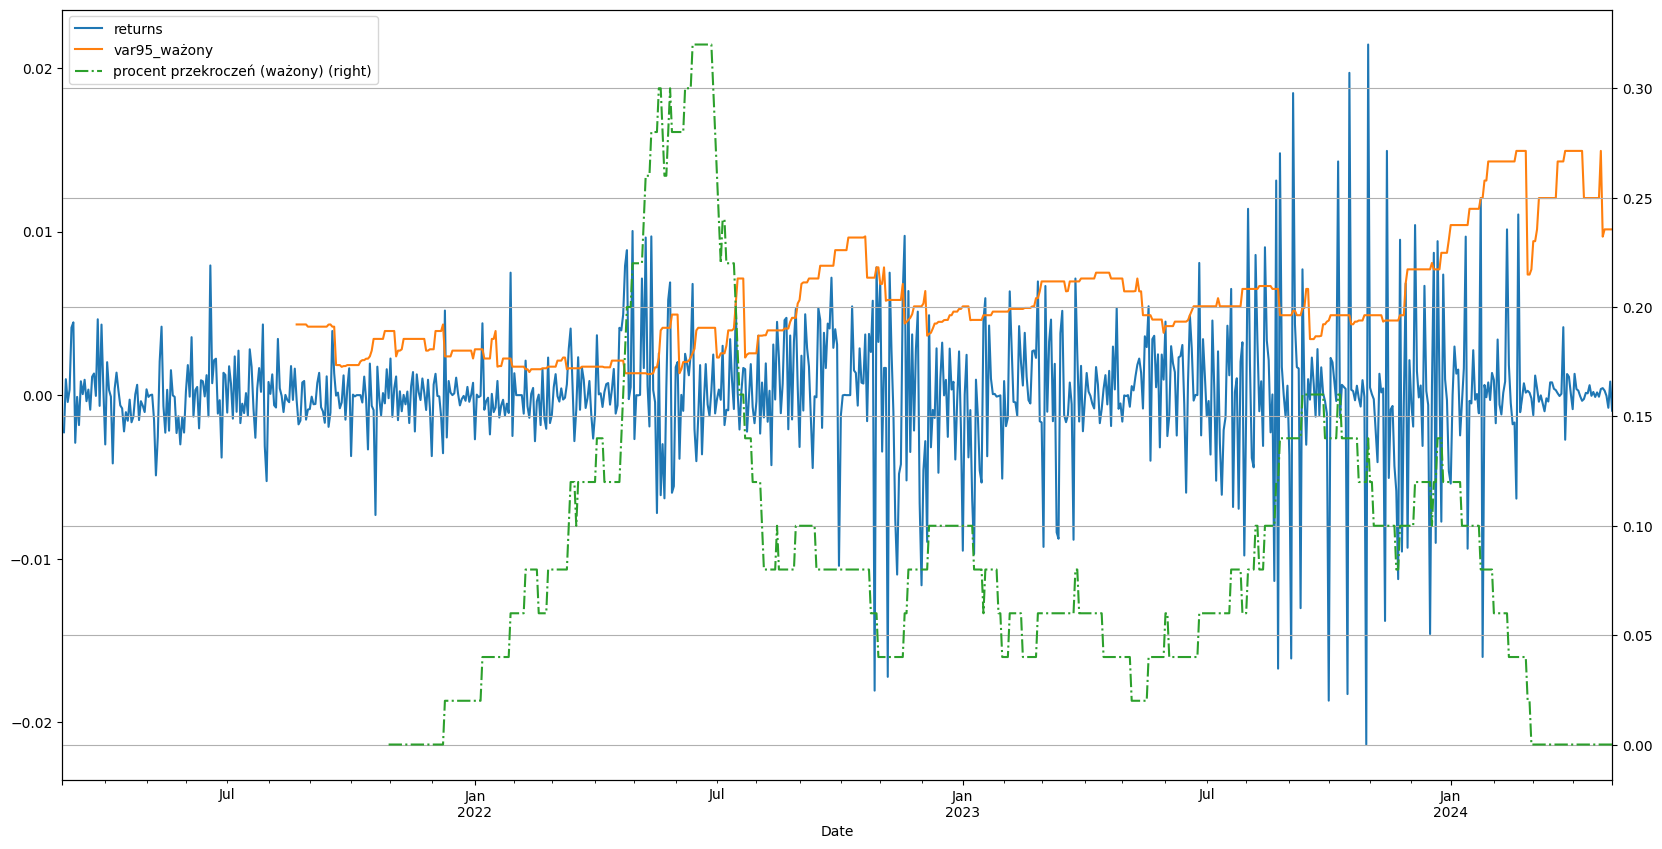

In [270]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_ważony', 'procent przekroczeń (ważony)']].\
    plot(ax=ax, secondary_y=['procent przekroczeń (ważony)'], grid=True,
         style=['-', '-', '-.'])

## Testowanie wsteczne

In [255]:
I_w = data.dropna().exceeds_ważony # wektor przekroczeń metoda ważona

### Rozkład dwumianowy

In [256]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'. \
      format(*map(lambda x: np.round(x, 3),
                  [I_w.mean(), alpha, 1 - alpha,
                   I_w.var(), alpha, alpha, alpha * (1 - alpha)])))

Średnia z przekroczeń = 0.089, 1 - 0.95 = 0.05.
Wariancja z przekroczeń = 0.081, 0.95(1 - 0.95) = 0.048.


In [257]:
stats.binomtest(int(I_w.sum()), n=I_w.size, p=1-alpha)

BinomTestResult(k=47, n=528, alternative='two-sided', statistic=0.08901515151515152, pvalue=0.0001860157776173812)